# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import pathlib as pl;         import os
import numpy as np;           import xarray as xr
import geopandas as gpd;
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from functools import partial
from scipy.signal import find_peaks
from scipy.sparse import coo_matrix
from shapely.geometry import Point

In [2]:

def compute_keep_idx(sample_path, min_depth, max_depth):
    """
    Return indices of nodes whose depth is between min_depth and max_depth,
    excluding fill‐values.
    """
    ds0   = xr.open_dataset(sample_path, engine="netcdf4", mask_and_scale=False)
    depth = ds0.depth.values
    fv    = ds0.depth.encoding.get("_FillValue", None)
    mask  = np.ones_like(depth, dtype=bool)
    if fv is not None:
        mask &= (depth != fv)                  # drop missing
    mask &= (depth >= min_depth)             # deeper than shore
    mask &= (depth <= max_depth)             # shallower than cutoff
    keep_idx = np.where(mask)[0]
    ds0.close()
    return keep_idx


def open_zeta_dataset(root_path, years, keep_idx,
                      chunks={"time":1000, "node":20000}):
    """
    Read each year’s CF‑ified file (no chunks at open), preprocess it,
    then chunk and concatenate along time.
    """
    ds_list = []
    for year in years:
        path = pl.Path(root_path) / str(year) / "fort.63.cf.nc"
        # 1) Open without chunks
        ds = xr.open_dataset(path,
                             engine="netcdf4",
                             mask_and_scale=False)

        # 2) Preprocess (time mask, spin‑up drop, node slice)
        ds = preprocess(ds, year, keep_idx)

        # 3) Now apply chunking on the cleaned dataset
        ds = ds.chunk(chunks)

        ds_list.append(ds)

    # 4) Concatenate all years along time
    return xr.concat(ds_list, dim="time")

def build_adjacency(global_conn, keep_idx):
    """
    Filter the global connectivity to only triangles fully inside keep_idx,
    remap to local indices, and build a CSR adjacency matrix.
    """
    # 1) select triangles whose 3 nodes are all in keep_idx
    mask_tri = np.all(np.isin(global_conn, keep_idx), axis=1)
    tri_filt = global_conn[mask_tri]

    # 2) build a map from global -> local
    local_map = {g: i for i, g in enumerate(keep_idx)}
    # 3) remap
    remap = np.vectorize(local_map.get)(tri_filt)

    # 4) assemble edges
    row = np.hstack([remap[:,0], remap[:,1],
                     remap[:,1], remap[:,2],
                     remap[:,2], remap[:,0]])
    col = np.hstack([remap[:,1], remap[:,0],
                     remap[:,2], remap[:,1],
                     remap[:,0], remap[:,2]])
    data = np.ones_like(row, dtype=int)

    N = len(keep_idx)
    return sparse.coo_matrix((data, (row, col)), shape=(N, N)).tocsr()


def compute_keep_idx2(
    sample_path,
    min_depth,
    max_depth,
    bbox=None,
):
    """
    Return indices of nodes whose depth is between min_depth and max_depth,
    optionally also lying within a bounding box in x/y.

    Parameters
    ----------
    sample_path : str or Path
        Path to a CF‑ified fort.63 file.
    min_depth, max_depth : float
        Depth range (inclusive) in meters.
    bbox : tuple of floats (min_x, max_x, min_y, max_y), optional
        If given, further restrict to nodes with:
           min_x <= x <= max_x  AND  min_y <= y <= max_y.

    Returns
    -------
    keep_idx : np.ndarray of int
        Indices of the `node` dimension satisfying your criteria.
    """
    ds0 = xr.open_dataset(sample_path, engine="netcdf4", mask_and_scale=False)
    
    # 1) depth mask
    depth = ds0.depth.values
    fv    = ds0.depth.encoding.get("_FillValue", None)
    mask = np.ones_like(depth, dtype=bool)
    if fv is not None:
        mask &= (depth != fv)
    mask &= (depth >= min_depth)
    mask &= (depth <= max_depth)

    # 2) optional bbox mask
    if bbox is not None:
        min_x, max_x, min_y, max_y = bbox
        x = ds0.x.values
        y = ds0.y.values
        mask &= (x >= min_x) & (x <= max_x)
        mask &= (y >= min_y) & (y <= max_y)

    ds0.close()
    return np.where(mask)[0]

In [3]:
lat1, lat2 = 56.5, 74
lon1, lon2 = -168.5, -140

In [4]:
root = '/scratch/tmiesse/project/data4spatial'
YEARS = range(1981, 2025)
MIN_DEPTH = -2
MAX_DEPTH = 2
bbox = (lon1, lon2, lat1, lat2)
sample_path = f"{root}/2023/fort.63.cf.nc"
keep_idx = compute_keep_idx2(
    sample_path=sample_path,
    min_depth=MIN_DEPTH,
    max_depth=MAX_DEPTH,
    bbox=bbox
)
print(f"Keeping {len(keep_idx)}")

Keeping 183897


In [5]:
sample_path = f"{root}/2023/fort.63.cf.nc"
keep_idx = compute_keep_idx2(
    sample_path=sample_path,
    min_depth=MIN_DEPTH,
    max_depth=MAX_DEPTH,
    bbox=bbox
)
print(f"Keeping {len(keep_idx)}")

Keeping 183897


In [6]:
global_conn = xr.open_dataset(sample_path, engine="netcdf4")["face_node_connectivity"].values - 1
adj         = build_adjacency(global_conn, keep_idx)

In [7]:
from dask.distributed import Client, LocalCluster
import math
n_workers   = int(os.environ.get("SLURM_NTASKS", "45"))
mem_per_cpu = os.environ.get("SLURM_MEM_PER_CPU", "72GB")

cluster = LocalCluster(
    n_workers=n_workers,
    threads_per_worker=1,
    processes=True,
    memory_limit=mem_per_cpu
)
client = Client(cluster)
print(client)
SPINUP_DAYS= 14
DROP_START = SPINUP_DAYS * 24

<Client: 'tcp://127.0.0.1:35417' processes=45 threads=45, memory=2.95 TiB>


In [8]:

SPINUP_HRS  = 14*24
def preprocess(ds):
    # 1) decode raw time → pandas
    ds = ds.assign_coords(time=pd.to_datetime(ds.time.values))
    # 2) drop anything outside that calendar year
    year = ds.time.dt.year.values[600]
    mask = ds.time.dt.year == year
    #ds = ds.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    # 3) drop the spin‑up
    ds = ds.isel(time=mask)
    # 4) subset to shallow nodes
    ds = ds.isel(node=keep_idx)
    return ds


In [9]:
paths = [str(pl.Path(root)/str(y)/"fort.63.cf.nc") for y in YEARS]
ds_all =  xr.open_mfdataset(
            paths,
            engine="h5netcdf",            # <- use h5netcdf instead of netcdf4
            mask_and_scale=True,   # ← automatically turn fill‐values into NaN
            decode_cf=True,        # ← apply CF conventions (including _FillValue)
            preprocess=preprocess,
            combine="nested",
            concat_dim="time",
            chunks={'time':24})

times  = ds_all.time.values      # length T
z = ds_all.zeta.values
#z = ds_all.zeta.values.astype(float)
x_all  = ds_all.x.values                          # (n_nodes,)
y_all  = ds_all.y.values                          # (n_nodes,)

client.close(),cluster.close()

2025-06-09 11:09:17,521 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-

(None, None)

In [ ]:
s3 = np.maximum.reduce([ z[2:  ,:],  # t  
                         z[1:-1,:],  # t–1  
                         z[:-2 ,:] ]) # t–2  
times_s3 = times[2:]
th1 = np.nanpercentile(s3,  95.0, axis=0)
th2 = np.nanpercentile(s3,  99.9, axis=0) 

In [ ]:
min_separation = 48   # hours

# — 2) Boolean mask: True wherever s3 ≥ high threshold
above = s3 >= th2[None, :]    # shape = (T‑2, N)

# — 3) Collect peak indices per node
peaks = {}  # node → array of indices in s3/time
for n in range(s3.shape[1]):
    idxs = np.where(above[:, n])[0]
    if idxs.size:
        # enforce min_separation between successive peaks
        sel = [idxs[0]]
        for i in idxs[1:]:
            if i - sel[-1] >= min_separation:
                sel.append(i)
        peaks[n] = np.array(sel)

print(f"Detected peaks on {len(peaks)} nodes")

Detected peaks on 171999 nodes



min_separation = 24   # hours
peaks = {}
for n in range(z.shape[1]):
    idx, props = find_peaks(
        s3[:, n],
        height=th2[n],
        distance=min_separation
    )
    if idx.size:
        peaks[n] = idx      # store peak‐indices (in s3)

print(f"Found peaks on {len(peaks)} nodes")
conn_da = ds_all.face_node_connectivity  # dims = (time, nele, nvertex)
# take the first time only
conn0 = conn_da.isel(time=0).values - 1  # now shape = (nele, nvertex)
_in      = np.isin(conn0, keep_idx)      # shape (nele, 3)
tri_mask = np.all(_in, axis=1)           # shape (nele,)
conn_flt = conn0[tri_mask, :]            # shape (n_flt, 3)

local_map = {g: i for i, g in enumerate(keep_idx)}
remap     = np.vectorize(local_map.get)(conn_flt)  # (n_flt, 3)

# 4) build symmetric adjacency graph
row = np.hstack([
    remap[:, 0], remap[:, 1],
    remap[:, 1], remap[:, 2],
    remap[:, 2], remap[:, 0],
])
col = np.hstack([
    remap[:, 1], remap[:, 0],
    remap[:, 2], remap[:, 1],
    remap[:, 0], remap[:, 2],
])
data = np.ones_like(row, dtype=bool)

adj = coo_matrix(
    (data, (row, col)),
    shape=(len(keep_idx), len(keep_idx))
).tocsr()

In [ ]:
def build_adjacency_v2(faces, keep_idx):
    """
    faces:    (nele, 3) array of zero‑based node indices for every triangle
    keep_idx: 1d array of global node IDs you want to keep

    Returns a CSR adjacency matrix over only the kept nodes.
    """
    # 1) pick only triangles whose 3 vertices are all in keep_idx
    in_keep = np.isin(faces, keep_idx)
    tri_mask = in_keep.all(axis=1)
    tri = faces[tri_mask]               # shape = (n_tris_kept, 3)

    # 2) build map global → local [0..N‑1]
    local_map = {g: i for i, g in enumerate(keep_idx)}

    # 3) remap each triangle to local indexing
    remap = np.vectorize(local_map.get)(tri)  # still (n_tris_kept, 3)

    # 4) list out all edges (both directions) for every triangle
    #    we stack 6 arrays: (0→1,1→0), (1→2,2→1), (2→0,0→2)
    row = np.hstack([
        remap[:, 0], remap[:, 1],
        remap[:, 1], remap[:, 2],
        remap[:, 2], remap[:, 0],
    ])
    col = np.hstack([
        remap[:, 1], remap[:, 0],
        remap[:, 2], remap[:, 1],
        remap[:, 0], remap[:, 2],
    ])

    data = np.ones_like(row, dtype=bool)
    N = len(keep_idx)
    # 5) build boolean adjacency
    return sparse.coo_matrix((data, (row, col)), shape=(N, N)).tocsr()

# finally build it:
adj = build_adjacency_v2(global_conn, keep_idx)

In [ ]:
mask1 = s3 >= th1[None, :]   # T×N, lower threshold
mask2 = s3 >= th2[None, :]   # T×N, higher threshold

# 2) Loop over every time slice where any node exceeds th2
footprints = {}
for t in sorted({t for sub in peaks.values() for t in sub}):
    nodes_t = [n for n, idxs in peaks.items() if t in idxs]
    subgraph = adj[nodes_t][:, nodes_t]
    labels, _ = connected_components(subgraph, directed=False)
    full = -1*np.ones(s3.shape[1], dtype=int)
    full[nodes_t] = labels
    footprints[t] = full

print(f"Extracted {len(footprints)} footprints at times: {list(footprints.keys())}")


In [ ]:
n_events = len(footprints)
print(f"Total surge events detected: {n_events}")

Total surge events detected: 17476


In [ ]:
event_idxs = sorted(footprints.keys())              # indices into s3/time
event_times = times_s3[event_idxs]                  # actual datetimes

# 2) Build feature‐matrix: for each event, a binary mask of nodes ≥ th1
X = mask1[event_idxs].astype(int)    

In [ ]:
event_idxs = sorted(footprints.keys())    # length = 1155
n_events   = len(event_idxs)
print("n_events:", n_events)

# 2) Pull out the kept‑node coords from your concatenated dataset:
x_kept = ds_all.x.values  # shape = (n_kept,)
y_kept = ds_all.y.values  # shape = (n_kept,)

# 3) For each event t, find the single node with max s3 above th2:
x_peak = np.empty(n_events)
y_peak = np.empty(n_events)

for i, t in enumerate(event_idxs):
    row       = s3[t, :]                       # length = n_kept
    masked    = np.where(row >= th2, row, -np.inf)
    local_idx = np.argmax(masked)               # index in 0…n_kept-1
    x_peak[i] = x_kept[local_idx]
    y_peak[i] = y_kept[local_idx]

# 4) Build coords array and check shape:
coords = np.column_stack([x_peak, y_peak])     # → shape (1155, 2)?
print("coords.shape:", coords.shape)
assert coords.shape == (n_events, 2)

n_events: 17476
coords.shape: (17476, 2)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


# 1) Compute each event’s best node & assemble coords + times
n_events = len(event_idxs)
event_local_idx = np.empty(n_events, dtype=int)
x_kept = ds_all["x"].values
y_kept = ds_all["y"].values

for i, t in enumerate(event_idxs):
    row    = s3[t, :]                       # surge at time t for every kept node
    masked = np.where(row >= th2, row, -np.inf)
    event_local_idx[i] = np.argmax(masked)  # best node in your keep_idx

coords = np.column_stack([
    x_kept[event_local_idx],
    y_kept[event_local_idx]
])  # shape = (n_events, 2)
event_times = times_s3[event_idxs]

# 2) Define parameter grid for DBSCAN
eps_vals         = list(np.arange(0.5,1.,0.2))   # degrees (~km)
min_samples_vals = [5,6,7,8,9,10]

best_score  = -1.0
best_params = None

# 3) Grid‐search for highest silhouette on non‐noise events
for eps in eps_vals:
    for ms in min_samples_vals:
        db = DBSCAN(eps=eps, min_samples=ms, metric="euclidean")
        labs = db.fit_predict(coords)
        
        # only consider “core” events (label ≥ 0)
        mask = labs >= 0
        nclus = len(np.unique(labs[mask]))
        if nclus < 2:
            continue
        
        score = silhouette_score(coords[mask], labs[mask])
        #print(f"eps={eps:.2f}, min_s={ms:2d} → clusters={nclus}, silhouette={score:.3f}")
        
        if score > best_score:
            best_score  = score
            best_params = (eps, ms)

eps_opt, ms_opt = best_params
print(f"\n→ Best params: eps={eps_opt}, min_samples={ms_opt}, silhouette={best_score:.3f}")

# 4) run DBSCAN with the optimal settings
db_opt     = DBSCAN(eps=eps_opt, min_samples=ms_opt, metric="euclidean")
labels_opt = db_opt.fit_predict(coords)  # -1=noise, 0..n_clusters-1

# 5) Build your final ds_events
ds_events = xr.Dataset(
    { "cluster": (("event",), labels_opt.astype(int)) },
    coords={
      "event": ("event", np.array(event_idxs, dtype=int)),
      "time":  ("event", event_times),
      "lon":   ("event", coords[:,0]),
      "lat":   ("event", coords[:,1]),
    }
)
out_path = "/scratch/tmiesse/project/surge_events.nc"
ds_events.to_netcdf(out_path)


→ Best params: eps=0.5, min_samples=9, silhouette=0.499


In [ ]:
foot_arr = np.stack([footprints[t] for t in event_idxs], axis=0)  
foot_da = xr.DataArray(
    foot_arr,
    dims=("event", "node"),
    coords={
        "event": ("event", event_idxs),
        "node":  ("node", keep_idx)
    },
    name="component"
)
ds_events = ds_events.assign(component=foot_da)
presence = (ds_events["component"] >= 0).astype(float)
avg_footprints = presence.groupby(ds_events["cluster"]).mean(dim="event")
counts = ds_events["cluster"].groupby(ds_events["cluster"]).count(dim="event")

In [ ]:
ev_times = pd.to_datetime(ds_events["time"].values).tz_localize(None)
s3_times = pd.to_datetime(times_s3).tz_localize(None)

# 2) Build the list of matching indices, catching any that fail
time_idx_list = []
missing = []
for t in ev_times:
    try:
        idx = s3_times.get_loc(t)
        time_idx_list.append(int(idx))
    except KeyError:
        missing.append(t)

# 3) Report
print(f"Events in ds_events : {len(ev_times)}")
print(f"Footprints available: {len(footprints)}")
print(f"Matched indices     : {len(time_idx_list)}")
if missing:
    print("Missing event times (no s3 match):")
    for t in missing:
        print(" ", t)
else:
    print("All event times matched successfully.")

Events in ds_events : 17476
Footprints available: 17476
Matched indices     : 17476
All event times matched successfully.


In [ ]:
comp_arr = ds_events["component"].data#np.stack(footprints)#[t] for t in global_event_times], axis=0)
#presence = (comp_arr >= 0).astype(int)
ecpn = presence.sum(axis=0).data

In [ ]:
cluster_labels = ds_events["cluster"].values                       # strings, length = n_events
unique_labels, inv = np.unique(cluster_labels, return_inverse=True)
cluster_codes = inv                                            # ints 0…n_clusters-1
counts_per_cluster = np.bincount(cluster_codes, minlength=unique_labels.size)


In [ ]:
ds_summary = xr.Dataset(
    data_vars={
        # connected‑component labels per event×node
        "component": (
            ("event","node"), comp_arr.astype(int)
        ),
        # numeric code per event
        "cluster_code": (
            ("event",), cluster_codes.astype(int)
        ),
        # how many events flooded each node
        "event_count_per_node": (
            ("node",), ecpn.astype(int)
        ),
        # how many events in each cluster
        "event_count_per_cluster": (
            ("cluster",), counts_per_cluster.astype(int)
        ),
        # string name for each cluster code
        "cluster_name": (
            ("cluster",), unique_labels.astype("U")
        ),
    },
    coords={
        "event":   ("event", ds_events["event"].values),
        "time":    ("event", ds_events["time"].values),   # only here, not in data_vars
        "node":    ("node", ds_all["node"].values),
        "x":       ("node", ds_all["x"].values),
        "y":       ("node", ds_all["y"].values),
        "cluster":("cluster", unique_labels),
    },
    attrs={
        "description":    "Surge‐event summary with cluster codes & names",
        "node_selection": f"depth {MIN_DEPTH}–{MAX_DEPTH} m",
        "spinup_hours":   SPINUP_HRS,
    }
)


# 4) Write to NetCDF
out_path = "/scratch/tmiesse/project/surge_cluster_summary_48hr.nc"
ds_summary.to_netcdf(out_path)

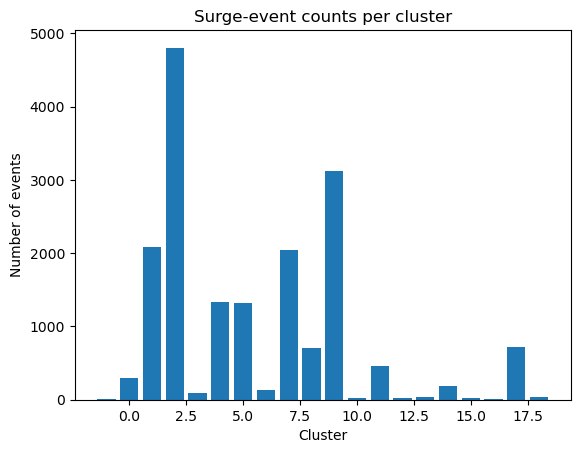

In [25]:
import matplotlib.pyplot as plt

plt.bar(counts["cluster"].values, counts.values)
plt.xlabel("Cluster")
plt.ylabel("Number of events")
plt.title("Surge‐event counts per cluster")
plt.show()

In [26]:
ds_events = ds_events.assign_coords(
    lon=("event", x_peak),
    lat=("event", y_peak)
)

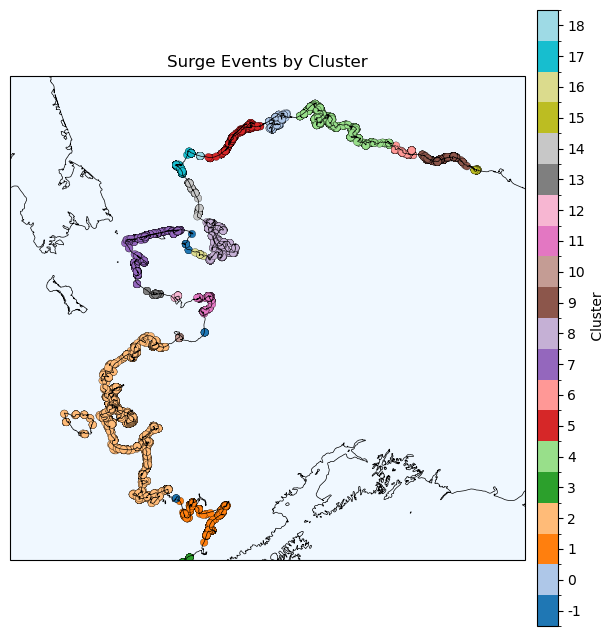

In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm



lat1, lat2 = 58, 71
lon1, lon2 = -167, -140
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
use_code = True

if use_code:
    cvals = ds_events["cluster"].values
    cmap  = "tab10"
    clabel = "Cluster Code"
else:
    # if you want to map names to integers, do that:
    names = ds_events["cluster"].values  # string cluster names
    unique, inv = np.unique(names, return_inverse=True)
    cvals = inv
    cmap  = "tab20"
    clabel = "Cluster Name"

# 2) Cluster those peak‐locations
names = ds_events["cluster"].values   # e.g. ['Bristol Bay Borough', ...] length = n_events
lon   = x_peak                              # your array of peak longitudes
lat   = y_peak                              # your array of peak latitudes

# 2) Build a mapping name→integer
unique_names, inv = np.unique(names, return_inverse=True)
# unique_names  shape = (n_clusters,)
# inv           shape = (n_events,) where inv[i] is the integer code for names[i]

# 3) Prepare discrete colormap & norm
nclus = unique_names.size
cmap  = plt.get_cmap("tab20", nclus)
norm  = BoundaryNorm(boundaries=np.arange(nclus+1)-0.5, ncolors=nclus)

# 4) Make the map
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))
ax.set_extent([-169, -140, 58, 71], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,  facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

# 5) Scatter using the integer codes
sc = ax.scatter(
    lon, lat,
    c=inv,
    cmap=cmap,
    norm=norm,
    s=30,
    edgecolor="k",
    linewidth=0.2,
    transform=ccrs.PlateCarree()
)

# 6) Add discrete colorbar with text labels
cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=30, ticks=np.arange(nclus))
cbar.ax.set_yticklabels(unique_names)
cbar.set_label(" Cluster")

plt.title("Surge Events by Cluster")
#plt.savefig(
#    '/scratch/tmiesse/project/figures/test.png',
#    dpi=300, bbox_inches='tight', pad_inches=0.1
#)
plt.show()

In [28]:
sample = pl.Path(root)/"2023"/"fort.63.cf.nc"
ds0    = xr.open_dataset(str(sample), engine="netcdf4", mask_and_scale=False)
x_all  = ds0.x.values                          # (n_nodes,)
y_all  = ds0.y.values                          # (n_nodes,)
# connectivity: drop time dim, zero‑base
conn0    = ds0.face_node_connectivity.values - 1  # now shape (nele, 3)
ds0.close()


In [29]:
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.tri as mtri
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

In [32]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 1) Build a pandas DataFrame for shallow‐water nodes
df = pd.DataFrame({
    "node":        keep_idx,           # global node IDs
    "x":           x_all[keep_idx],    # X coordinates
    "y":           y_all[keep_idx],    # Y coordinates
    "event_count": ecpn                # events per node
})

# 2) Create Point geometries
df["geometry"] = [Point(x, y) for x, y in zip(df.x, df.y)]

# 3) Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 4) Save to a shapefile
out_path = "/scratch/tmiesse/project/event_count/event_counts48hr.shp"
gdf.to_file(out_path)

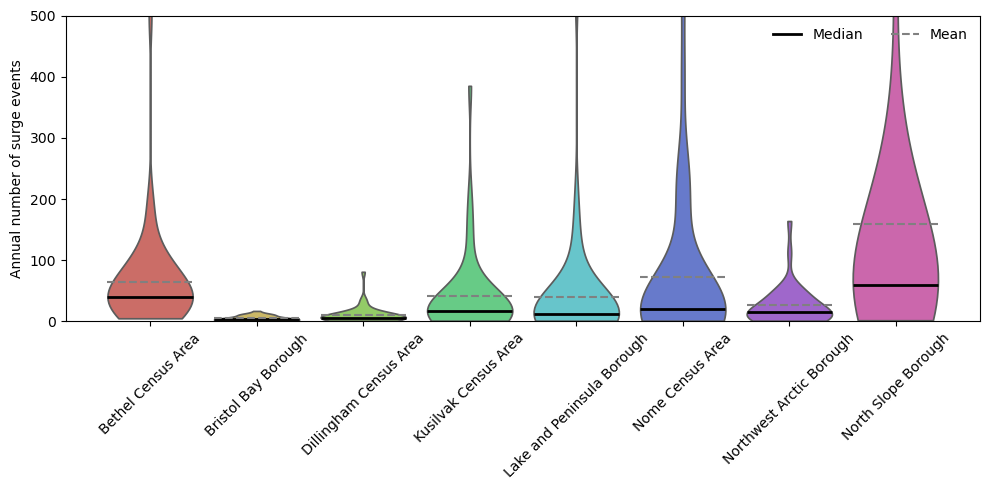

In [33]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import matplotlib.lines as mlines

# 1) Read & buffer county polygons
counties = (
    gpd.read_file("/scratch/tmiesse/project/counties/counties_wgs2.shp")
       .to_crs("EPSG:3338")
)
counties["geometry"] = counties.geometry.buffer(1)   # 1 km offshore buffer
counties = counties.to_crs("EPSG:4326")


# 2) Build events DataFrame
events = pd.DataFrame({
    "time": ds_events["time"].values,
    "lon":  ds_events["lon"].values,
    "lat":  ds_events["lat"].values,
})
events["time"] = pd.to_datetime(events["time"])
events["year"] = events["time"].dt.year

# 3) Convert to GeoDataFrame
gdf_ev = gpd.GeoDataFrame(
    events,
    geometry=[Point(x, y) for x, y in zip(events.lon, events.lat)],
    crs="EPSG:4326"
)

# 4) Spatial‐join events → counties
gdf = (
    gpd.sjoin(
        gdf_ev,
        counties[["CommunityN","geometry"]],
        how="left",
        predicate="within"
    )
    .rename(columns={"CommunityN":"county"})
    .drop(columns=["index_right"])
)

# 5) Count events per county per year
df_counts = (
    gdf
    .groupby(["county","year"])
    .size()
    .reset_index(name="n_events")
    .dropna(subset=["county"])
)

# 6) Prepare colors
max_per_county = df_counts.groupby("county")["n_events"].max()
plot_counties  = max_per_county[max_per_county >= 5].index.tolist()

# (optional) force “North Slope Borough” last
if "North Slope Borough" in plot_counties:
    plot_counties.remove("North Slope Borough")
    plot_counties.append("North Slope Borough")

# rebuild palette just for those counties
palette  = sns.color_palette("hls", len(plot_counties))
col_dict = dict(zip(plot_counties, palette))

# 7) Plot only those counties
fig, ax = plt.subplots(figsize=(10,5))
sns.violinplot(
    data=df_counts,
    x="county",
    y="n_events",
    order=plot_counties,   # <-- only the counties with max ≥5
    palette=col_dict,
    inner=None,
    scale="width",
    cut=0,
    ax=ax
)
ax.set_ylim(0, 500)
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=45, labelsize=10)
ax.set_ylabel("Annual number of surge events")

# 8) Over‐plot median & mean
violin_width = 0.8
for i, county in enumerate(plot_counties):
    vals = df_counts.loc[df_counts.county==county, "n_events"].values
    med  = np.median(vals)
    mean = np.mean(vals)
    left  = i - violin_width/2
    right = i + violin_width/2
    # median: solid black
    ax.hlines(med, left, right, colors="black", linewidth=2)
    # mean: dashed gray
    ax.hlines(mean, left, right, colors="gray", linestyle="--", linewidth=1.5)

# 9) Legend for median & mean
median_proxy = mlines.Line2D([], [], color="black",   linewidth=2,  label="Median")
mean_proxy   = mlines.Line2D([], [], color="gray",    linestyle="--", linewidth=1.5, label="Mean")
ax.legend(
    handles=[median_proxy, mean_proxy],
    loc="upper right",
    ncol=2,
    framealpha=0.8,
    frameon=False,
)

plt.tight_layout()
plt.savefig(
    '/scratch/tmiesse/project/figures/county_violins.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

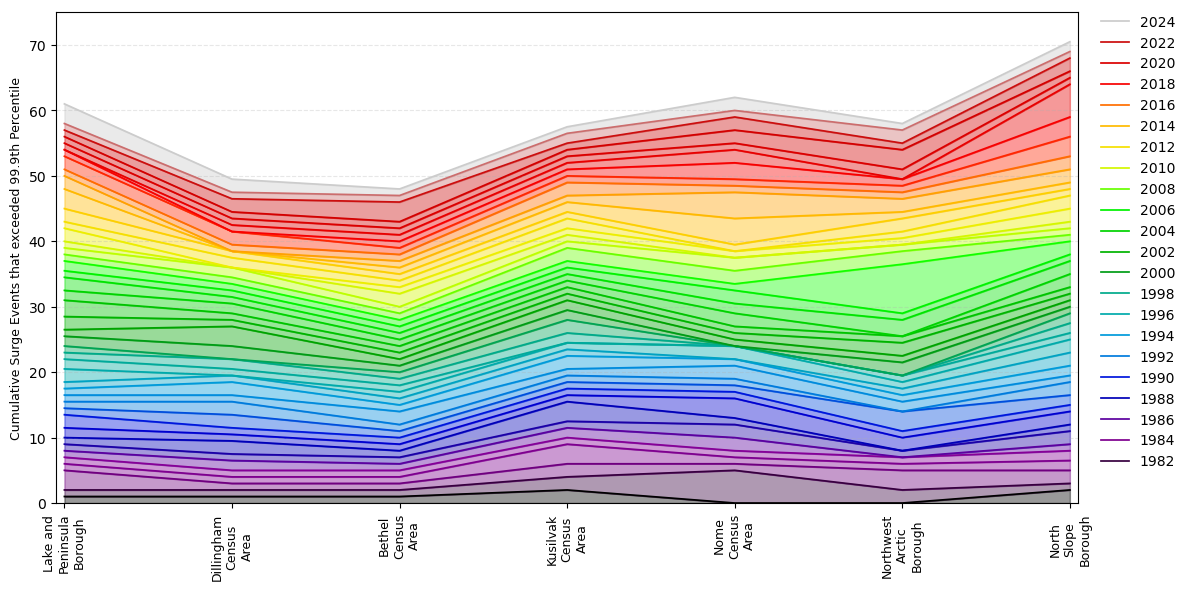

In [34]:
# 0) your list & shapefile
counties_order = [
    "Lake and Peninsula Borough",
    "Dillingham Census Area",
    "Bethel Census Area",
    "Kusilvak Census Area",
    "Nome Census Area",
    "Northwest Arctic Borough",
    "North Slope Borough",
]
counties = (
    gpd.read_file("/scratch/tmiesse/project/counties/counties_wgs2.shp")
       .to_crs("EPSG:3338")
)
counties["geometry"] = counties.geometry.buffer(1)   # 1 m offshore buffer
counties = counties.to_crs("EPSG:4326")

# 1) Build the raw events table *including* each event’s node index:
#    event_local_idx[i] is the kept-node index for event i, 
#    times_s3[i]  is its timestamp.
events = pd.DataFrame({
    "event": np.arange(len(event_local_idx)),
    "time":  pd.to_datetime(event_times),
    "node":  event_local_idx,
})
events["year"] = events.time.dt.year

# 2) Turn into a GeoDataFrame so we can spatially join to the same counties2.shp
#    We need x,y per event:
x_kept = ds_all["x"].values    # (n_kept,)
y_kept = ds_all["y"].values
events["lon"] = x_kept[events["node"]]
events["lat"] = y_kept[events["node"]]

gdf_ev = gpd.GeoDataFrame(
    events,
    geometry=[Point(lon, lat) for lon,lat in zip(events.lon, events.lat)],
    crs="EPSG:4326"
)

# 3) Spatial‐join → each event now has a "county" label
gdf = (
    gpd.sjoin(
        gdf_ev,
        counties[["CommunityN","geometry"]],
        how="left",
        predicate="intersects"
    )
    .rename(columns={"CommunityN":"county"})
    .drop(columns=["index_right"])
)
# drop any events that never landed in a county polygon
gdf = gdf.dropna(subset=["county"])

# 4) Exclude the partial 1981 if you like
#gdf = gdf[gdf.year != 1981]

# 5) Count events *per node* in each (county, year)
df_node = (
    gdf
    .groupby(["county","year","node"])
    .size()
    .reset_index(name="node_event_count")
)

# 6) Average across nodes → one value per (county, year)
df_avg = (
    df_node
    .groupby(["county","year"])["node_event_count"]
    .median()
    .reset_index(name="avg_events_per_node")
)

# 7) Pivot to get a years×counties table, in your desired order
df_yearly_avg = (
    df_avg
    .pivot(index="year",
           columns="county",
           values="avg_events_per_node")
    .reindex(columns=counties_order).fillna(0)
    # if you’d rather see NaN for truly‐missing counties instead of zeros:
    # .fillna(0)
)

# 8) Cumulative sum down each county
cum = df_yearly_avg.cumsum(axis=0)

# 9) Finally, plot exactly as you had it
import matplotlib.pyplot as plt

x      = np.arange(len(counties_order))
years  = cum.index.values
cmap   = plt.get_cmap("nipy_spectral", len(years))

fig, ax = plt.subplots(figsize=(12,6))
prev = np.zeros(len(counties_order))

for i, yr in enumerate(years):
    y     = cum.loc[yr].values
    color = cmap(i)
    ax.fill_between(x, prev, y, color=color, alpha=0.4)
    ax.plot(x, y, color=color, linewidth=1.25, label=str(yr))
    prev = y

ax.set_xticks(x)
ax.set_xticklabels(counties_order, rotation=90, ha="right",fontsize=9)
ax.set_ylabel("Cumulative Surge Events that exceeded 99.9th Percentile",fontsize=9)
ax.set_ylim([0,75]),ax.set_xlim(x[0] - 0.05, x[-1] + 0.05)
#ax.set_title("Year‐by‐year cumulative average node‑events by county")

# Legend: first, middle, last
handles, labels = ax.get_legend_handles_labels()
sample_years = [years[0], years[len(years)//2], years[-1]]

#sel_l = [labels.index(str(y)) for y in sample_years]
#sel_h = [handles.index(str(y)) for y in sample_years]
import textwrap

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=90,ha="center")
wrap_labels(ax, 10) # Wrap labels at a width of 10 characters
ax.legend(
    handles[::-2],
    labels[::-2],
    loc="upper left",
    bbox_to_anchor=(1.01, 1.02),
    ncol=1,
    fontsize=10,
    frameon=False
)

ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(
    '/scratch/tmiesse/project/figures/cumulative_events.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()